## Step 2: Pre-processing rasters before passing to the stratification notebook

Before the rasters can be used for any ML work they need to be pre-processed to make sure the data is all aligned, and in a format that the ML model can accept. 

Pre-processing steps:
- all incoming data using same spatial projection (and if not, they have to be reprojected)
- Chek and set the nodata values for the rasters (scikit clustering algorithms don't like `NaN` so and incoming rasters using this value need to have their metadata updated and pixels replaced)
- pixel validatiuon - check there are no `inf` values or values greater than potential nodata values for float64 (surprisingly, this was an issue)
- Determine which raster in the input data folder as the finest pixel resolution - all the other rasters will need to be resampled to match this as all pixels going into the clustering algorithm need to be the same size.
- resample all of the rasters in the input directory to match the spatial resolution (pixel size) of the finest resolution raster
- ensure the spatial extent of the resampled rasters matches perfectly
- interpolate pixel values at the edges of the rasters after reasmpling if there are any that are now `NaN` or empty
- save the processed rasters as COGs into a new directory that will be used in Step 3.

Todo/ to consider:
- normalise/ scale pixel values
- enforcing types using pydantic?
- create data cube to avoid needing to stack rasters whenimporting in step 3/ notebook 3

some resources to check later:
https://discourse.pangeo.io/t/advice-for-scalable-raster-vector-extraction/4129

In [9]:
# %pip install pydantic -q

In [10]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
import rioxarray.merge
import logging

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("debug.log"),
                        logging.StreamHandler()
                    ])

warnings.filterwarnings('ignore', message="The `squeeze` kwarg to GroupBy is being removed.*")

The RasterProcessor class handles the bulk of the pre-processing. Each step is chained together, so that the outputs of one check are passed to the next check. That way we're sure at the end that every step has been applied. Logging info messages have been added to each step soo you can keep track of that is happening.

In [11]:
class RasterProcessor:
    def __init__(self, input_dir, output_dir, target_crs='EPSG:3857'):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.target_crs = target_crs
        self.data_arrays = self.load_rasters()
        self.filenames = self.get_filenames()
        self.num_rasters = len(self.data_arrays)
        self.finext_x_res = None
        self.finest_y_res = None
        self.finest_raster = self.find_finest_raster()

    def load_rasters(self):
        data_arrays = []
        for raster_file in os.listdir(self.input_dir):
            if raster_file.endswith('.tiff') or raster_file.endswith('.tif'):
                raster_path = os.path.join(self.input_dir, raster_file)
                # Open the raster file as an xarray DataArray with rioxarray
                data_array = rioxarray.open_rasterio(raster_path)
                data_arrays.append(data_array)
        return data_arrays
    
    def get_filenames(self):
        filenames = []
        for raster_file in os.listdir(self.input_dir):
            if raster_file.endswith('.tiff') or raster_file.endswith('.tif'):
                fpath = os.path.join(self.input_dir, raster_file)
                fname = os.path.basename(fpath)
                filenames.append(fname)
        return filenames

    def find_finest_raster(self):
        logging.info("Finding the finest raster in the dataset.")
        finest_res = float('inf')
        finest_raster = None
        
        for da in self.data_arrays:
            current_res = abs(da.rio.resolution()[0])
            if current_res < finest_res:
                finest_res = current_res
                finest_raster = da
        self.finest_raster = finest_raster
        logging.info(f"Finest raster found with resolution: {finest_res}")
        return self   

    def projection_check(self):
        reprojected_data_arrays = []
        logging.info(f"Checking CRS for {self.num_rasters} raster data arrays.")
        for da in self.data_arrays:
            if da.rio.crs != self.target_crs:
                logging.info(f"Reprojecting {da.rio.crs} to {self.target_crs}")
                reprojected_da = da.rio.reproject(self.target_crs)
                reprojected_data_arrays.append(reprojected_da)
            else:
                logging.info(f"Data array is already in the target CRS: {self.target_crs}")
                reprojected_data_arrays.append(da)
        self.data_arrays = reprojected_data_arrays
        return self
    

    def set_nodata(self):
        nodata_set_arrays = []
        logging.info(f"Setting NoData to -9999 for {self.num_rasters} raster data arrays.")
        for da in self.data_arrays:
            original_nodata = da.rio.nodata
            input_da = da.astype("float32")
            # Replace original NoData with NaN in float32
            if original_nodata is not None:
                input_da = input_da.where(input_da != original_nodata, -9999)
            
            input_da.rio.write_nodata(-9999, inplace=True)
            input_da.rio.set_nodata(-9999, inplace=True)
            nodata_set_arrays.append(input_da)
        self.data_arrays = nodata_set_arrays
        return self
    
    def validate_data(self):
        validated_data_arrays = []
        logging.info(f"Validating data for {self.num_rasters} raster data arrays.")
        for da in self.data_arrays:
            # Check for infinite values and replace them with NaN
            da = da.where(np.isfinite(da), np.nan)

            # Check for values too large for float64, although this is highly unlikely to exceed
            # the max float64 value in normal geospatial data scenarios.
            max_float64 = 1.797e+308
            da = da.where(da < max_float64, np.nan)

            validated_data_arrays.append(da)

        self.data_arrays = validated_data_arrays
        return self
    

    def resample_match(self):
        logging.info("Resampling all rasters to match the finest raster.")
        # because of small differences in coordinates dur to floating precision, also make sure to use assign_coords so all rasters have identical extents.
        resampled_data_arrays = []
        for da in self.data_arrays:
            if da is not self.finest_raster:
                # Reproject the data array to match the resolution of the finest data array
                resampled_da = da.rio.reproject_match(self.finest_raster)
                resampled_da = resampled_da.assign_coords(x=self.finest_raster.x, y=self.finest_raster.y)
                resampled_da = resampled_da.rio.interpolate_na(method="nearest")  # Ensure interpolation is the last step
                resampled_data_arrays.append(resampled_da)
            else:
                resampled_da = da.rio.interpolate_na(method="nearest")  # Apply also for the finest raster
                resampled_data_arrays.append(resampled_da)
        self.data_arrays = resampled_data_arrays
    
    def process(self):
        self.projection_check()
        self.validate_data()
        self.set_nodata()
        self.find_finest_raster()
        self.resample_match()
        return self
    
    def get_processed_data(self):
        return self.data_arrays
    

In [12]:
def save_as_cog(data_arrays, filenames, output_dir):

    for data_array, filename in zip(data_arrays, filenames):
        new_filename = filename.replace('.tif', '_processed.tif')
        output_path = os.path.join(output_dir, new_filename)  # Construct the full output path
        # Save using rio-cogeo
        data_array.rio.to_raster(output_path, driver='COG')

Commented out for now as the resampling method is currently hardcoded, but there are different pixel downsampling/upsampling methods that can be called. IF we allow this, use a class like this to make sure only valid methods are passed to the raster resampling function.

In [13]:
# class ResamplingMethods:
#     NEAREST = "nearest"
#     BILINEAR = "bilinear"
#     CUBIC = "cubic"

Set the input directory (where the unprocessed rasters are stored from step 1) and the output directory - the directory that will be used in step 3.

In [14]:
input_raster_dir = "/workspace/notebooks/sandbox/data/stratification/input-rasters"
output_raster_dir = "/workspace/notebooks/sandbox/data/stratification/processed-rasters"


Call the RasterProcessor, pass it the input and output directories, and let it do its thing.

Also set the CRS that we want all of the pre-processed data to be in (no reprojections are being done during the raster download in step 1, it is being done here).

In [15]:
processor = RasterProcessor(input_raster_dir, output_raster_dir, target_crs='EPSG:3857')
processor.process()
processed_data_arrays = processor.get_processed_data()

save_as_cog(processed_data_arrays, processor.filenames, output_raster_dir)

2024-06-26 23:35:58,100 - INFO - Finding the finest raster in the dataset.
2024-06-26 23:35:58,102 - INFO - Finest raster found with resolution: 0.0002776493047292413
2024-06-26 23:35:58,103 - INFO - Checking CRS for 2 raster data arrays.
2024-06-26 23:35:58,105 - INFO - Reprojecting EPSG:32750 to EPSG:3857
2024-06-26 23:35:58,118 - INFO - Found credentials in environment variables.
2024-06-26 23:35:58,153 - INFO - Found credentials in environment variables.
2024-06-26 23:35:58,170 - INFO - Reprojecting EPSG:4326 to EPSG:3857
2024-06-26 23:35:58,183 - INFO - Found credentials in environment variables.
2024-06-26 23:35:58,196 - INFO - Found credentials in environment variables.
2024-06-26 23:35:58,206 - INFO - Validating data for 2 raster data arrays.
2024-06-26 23:35:58,212 - INFO - Setting NoData to -9999 for 2 raster data arrays.
2024-06-26 23:35:58,216 - INFO - Finding the finest raster in the dataset.
2024-06-26 23:35:58,217 - INFO - Finest raster found with resolution: 22.96075863

2024-06-26 23:35:58,498 - INFO - Found credentials in environment variables.
2024-06-26 23:35:58,753 - INFO - Found credentials in environment variables.
2024-06-26 23:35:58,815 - INFO - Found credentials in environment variables.


This part of the code is not needed for pre-processing - it just plots the final rasters so you can check that they still look correct.

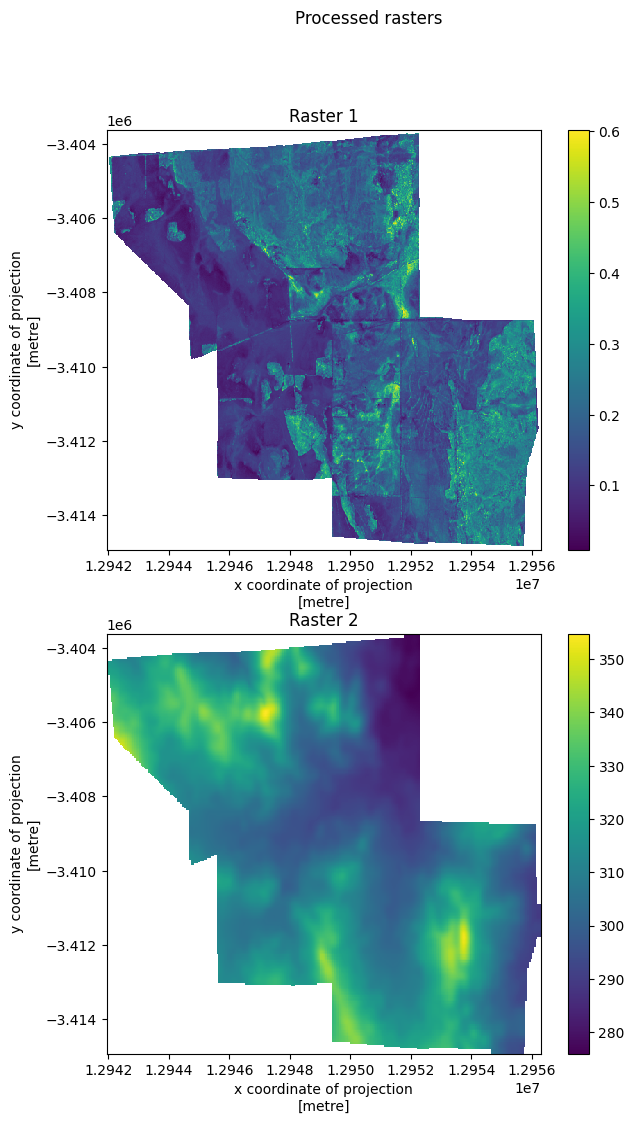

In [16]:
n = len(processed_data_arrays)
cols = 1
rows = n

fig, axs = plt.subplots(rows, cols, figsize = (7 * cols, 6 * rows))
fig.suptitle("Processed rasters")

axs = axs.flatten()

for i, raster in enumerate(processed_data_arrays):
    raster.plot(ax = axs[i])
    axs[i].set_title(f"Raster {i+1}")